[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

In [ ]:
!pip -q install sktime pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 11.0 MB/s eta 0:00:00


# Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sktime

In [ ]:
# Download dataset

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle competitions download -c store-sales-time-series-forecasting

! unzip "store-sales-time-series-forecasting.zip"

 42% 9.00M/21.4M [00:00<00:00, 79.1MB/s]
100% 21.4M/21.4M [00:00<00:00, 125MB/s] 
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


# Former EDA

In [ ]:
# Import the training and validation sets.
# store_sales = pd.read_csv("train.csv",
#                  parse_dates=['date'],
#                  infer_datetime_format=True,
#                  low_memory=False)

# store_sales = store_sales.set_index('date').to_period('D')

<ipython-input-42-2b0044de4f49>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv("train.csv",


In [ ]:
# Select just one date item if multiple
# store_sales = store_sales.groupby(store_sales.index).first()

# # Remove instances with empty target
# store_sales = store_sales[store_sales['sales'] != 0]

#Resample
# store_sales = store_sales.resample('D').asfreq().fillna(0)

# store_sales

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-02,1782,1,AUTOMOTIVE,2.0,0
2013-01-03,3564,1,AUTOMOTIVE,3.0,0
2013-01-04,5346,1,AUTOMOTIVE,3.0,0
2013-01-05,7128,1,AUTOMOTIVE,5.0,0
...,...,...,...,...,...
2017-08-11,2991978,1,AUTOMOTIVE,1.0,0
2017-08-12,2993760,1,AUTOMOTIVE,6.0,0
2017-08-13,2995542,1,AUTOMOTIVE,1.0,0


#New EDA

In [ ]:
# Import the training and validation sets.
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

<ipython-input-6-450bc60d1d28>:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, (Period('2013-01-01', 'D'), '1', 'AUTOMOTIVE') to (Period('2017-08-15', 'D'), '9', 'SEAFOOD')
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   sales        float32
 2   onpromotion  uint64 
dtypes: float32(1), int64(1), uint64(1)
memory usage: 68.8 MB


Data Visualization

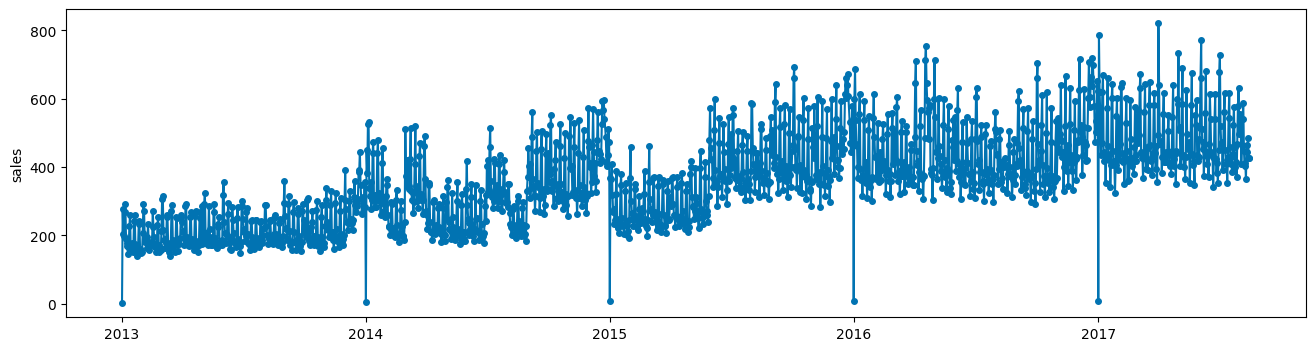

In [ ]:
from sktime.utils import plot_series

y = average_sales

_ = plot_series(y)

In [ ]:
y.head()

2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

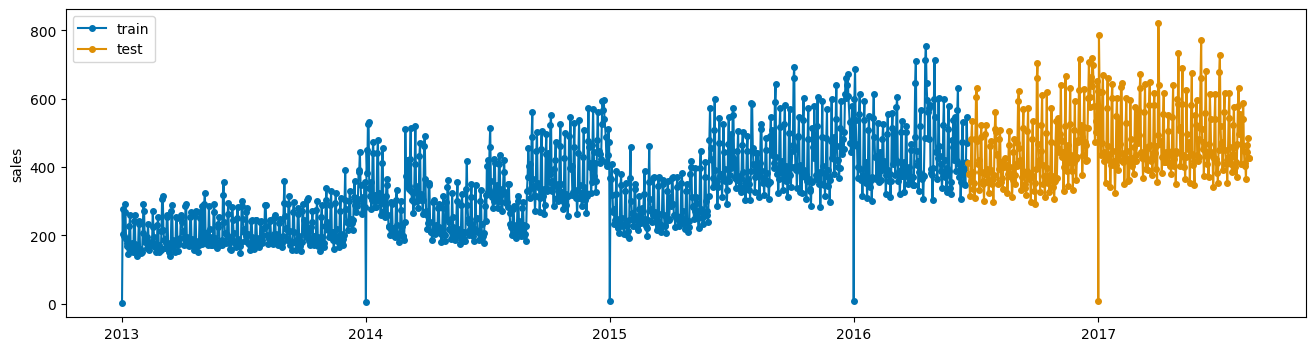

In [ ]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y)

_ = plot_series(y_train, y_test, labels=["train", "test"])

In [ ]:
y_test.head()

2016-06-20    412.881256
2016-06-21    381.171722
2016-06-22    380.320221
2016-06-23    314.059113
2016-06-24    360.164246
Freq: D, Name: sales, dtype: float32

Using the exponential smoothing model...



# Modelling

In [ ]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

AutoETS(auto=True)

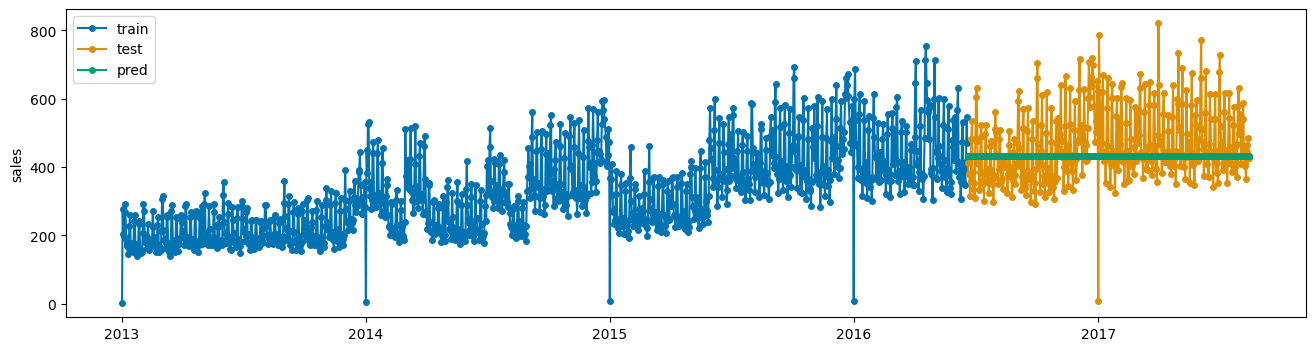

In [ ]:
# 3) Use fitted model to predict for a certain forecast horizon (fh)
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

_ = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

In [ ]:
# forecasting performance metrics
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoETS - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoETS - sMAPE error: 16.7%


You should check out other metrics to see what is applicable where.

# Exogenous Features

In [ ]:
X = store_sales["onpromotion"]
y = store_sales["sales"]

In [ ]:
y.info()

<class 'pandas.core.series.Series'>
MultiIndex: 3000888 entries, (Period('2013-01-01', 'D'), '1', 'AUTOMOTIVE') to (Period('2017-08-15', 'D'), '9', 'SEAFOOD')
Series name: sales
Non-Null Count    Dtype  
--------------    -----  
3000888 non-null  float32
dtypes: float32(1)
memory usage: 23.0 MB


In [ ]:
X.info()

<class 'pandas.core.series.Series'>
MultiIndex: 3000888 entries, (Period('2013-01-01', 'D'), '1', 'AUTOMOTIVE') to (Period('2017-08-15', 'D'), '9', 'SEAFOOD')
Series name: onpromotion
Non-Null Count    Dtype 
--------------    ----- 
3000888 non-null  uint64
dtypes: uint64(1)
memory usage: 34.4 MB


In [ ]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X)

TypeError: y must be in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. Allowed compatible mtype format specifications are: ['pd.Series', 'pd.DataFrame', 'np.ndarray', 'nested_univ', 'numpy3D', 'pd-multiindex', 'df-list', 'pd_multiindex_hier']See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynb, If you think y is already in an sktime supported input format, run sktime.datatypes.check_raise(y, mtype) to diagnose the error, where mtype is the string of the type specification you want for y. 

In [ ]:
from sktime.forecasting.arima import ARIMA

forecaster_without_X = ARIMA()
forecaster_with_X = ARIMA()

fh = np.arange(1, len(y_test.index)+1)

forecaster_without_X.fit(y_train, fh=fh)
forecaster_with_X.fit(y_train, X=X_train, fh=fh)

y_pred_without_X = forecaster_without_X.predict()
y_pred_with_X = forecaster_with_X.predict(X=X_test)

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X,
    labels=["y_train", "y_test", "y_pred_without_X", "y_pred_with_X"],
    title="Forecast with exogenous features",
)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"ARIMA - y_pred_without_X sMAPE error: {smape(y_test, y_pred_without_X):.1%}")
print(f"ARIMA - y_pred_with_X sMAPE error: {smape(y_test, y_pred_with_X):.1%}")

ARIMA - y_pred_without_X sMAPE error: 61.9%
ARIMA - y_pred_with_X sMAPE error: 61.6%


Not all forecasters in sktime support exogenous features

# Multivariate forecasting